# Import Packages

In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.utils.data import Dataset, random_split
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import struct

# Custom Dataset Class

In [2]:
class MNISTDataset(Dataset):
    def __init__(self, images_path, labels_path, transform=None):
        """
        Custom Dataset for MNIST using uncompressed .ubyte files.

        Args:
            images_path (str): Path to the images .ubyte file.
            labels_path (str): Path to the labels .ubyte file.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.images = self._load_images(images_path)
        self.labels = self._load_labels(labels_path)
        self.transform = transform

    def _load_images(self, filepath):
        with open(filepath, 'rb') as f:
            # Read magic number, number of images, rows, and columns
            magic, num, rows, cols = struct.unpack(">IIII", f.read(16))

            # Verify the expected size (60,000 images x 784 pixels)
            expected_size = num * rows * cols
            data = np.frombuffer(f.read(), dtype=np.uint8)

            # Ensure data is of expected size (60000 * 784 for training images)
            if data.size != expected_size:
                raise ValueError(f"Expected {expected_size} bytes, but got {data.size}.")

            # Reshape the data into (num_images, 1, 28, 28)
            data = data.reshape(num, rows, cols)

        return torch.tensor(data, dtype=torch.float32) / 255.0  # Normalize to [0, 1]

    def _load_labels(self, filepath):
        with open(filepath, 'rb') as f:
            # Read magic number, number of labels
            magic, num = struct.unpack(">II", f.read(8))
            # Read label data
            data = np.frombuffer(f.read(), dtype=np.uint8)

        return torch.tensor(data, dtype=torch.int64)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label


# Data Preprocessing

In [6]:
!ls

sample_data		t10k-labels.idx1-ubyte	 train-labels.idx1-ubyte
t10k-images.idx3-ubyte	train-images.idx3-ubyte


In [7]:
# Transform for data normalization
transform = transforms.Compose([transforms.Lambda(lambda x: x.unsqueeze(0)), transforms.Normalize((0.5,), (0.5,))])

# Paths to MNIST .gz files
train_images_path = "train-images.idx3-ubyte"
train_labels_path = "train-labels.idx1-ubyte"
test_images_path = "t10k-images.idx3-ubyte"
test_labels_path = "t10k-labels.idx1-ubyte"

# Create Dataset instances
training_dataset = MNISTDataset(train_images_path, train_labels_path, transform=transform)
test_dataset = MNISTDataset(test_images_path, test_labels_path, transform=transform)
print("training dataset size: ", len(training_dataset))
print("test dataset size: ", len(test_dataset))

# Splitting Dataset into Training and Validation Sets
val_size = len(training_dataset) // 6  # 1/6 for validation
train_size = len(training_dataset) - val_size

train_dataset, val_dataset = random_split(training_dataset, [train_size, val_size])

print("Training dataset size after splitting:", len(train_dataset))
print("Validation dataset size after splitting:", len(val_dataset))
print("Testing dataset size remains unchanged:", len(test_dataset))

training dataset size:  60000
test dataset size:  10000
Training dataset size after splitting: 50000
Validation dataset size after splitting: 10000
Testing dataset size remains unchanged: 10000


# General class for our Neural Network Architectures

In [8]:
# Define the Feedforward Neural Network class
class FeedforwardNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_layers, hidden_units, learning_rate, batch_size):
        super(FeedforwardNN, self).__init__()

        # Save learning rate and batch size for later use
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.input_size = input_size
        self.output_size = output_size

        # Create the layers of the neural network
        layers = []
        in_features = input_size
        for _ in range(hidden_layers):
            layers.append(nn.Linear(in_features, hidden_units))
            layers.append(nn.ReLU())  # Activation function for hidden layers
            in_features = hidden_units

        # Output layer
        layers.append(nn.Linear(in_features, output_size))

        # Combine layers in a sequential model
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# Train and Test Functions

In [9]:
# Define train_model and test_model functions
def train_model(model, train_dataset, val_dataset, criterion, optimizer, batch_size, input_size, epochs=10):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        # Training phase
        model.train()
        running_train_loss = 0.0
        for images, labels in train_loader:
            images = images.reshape(-1, input_size)
            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()

        train_loss = running_train_loss / len(train_loader)
        train_losses.append(train_loss)

        # Validation phase
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.reshape(-1, input_size)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()

        val_loss = running_val_loss / len(val_loader)
        val_losses.append(val_loss)

        print(f"Epoch [{epoch + 1}/{epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    return train_losses, val_losses

In [10]:
def test_model(model, test_dataset, input_size):
    test_loader = DataLoader(test_dataset, batch_size=model.batch_size, shuffle=False)
    n_correct = 0
    n_samples = len(test_loader.dataset)

    all_preds = []
    all_labels = []

    for images, labels in test_loader:
        images = images.reshape(-1, input_size)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        n_correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    acc = n_correct / n_samples
    print(f"Accuracy: {100 * acc:.2f} %")
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(model.output_size), yticklabels=range(model.output_size))
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

    return acc

In [11]:
def plot_loss_curves(train_loss_curves, val_loss_curves, params, param_name):
    """
    Plots the training and validation loss curves for multiple parameter values in separate plots.

    Args:
        train_loss_curves (dict): Training loss curves for each parameter value.
        val_loss_curves (dict): Validation loss curves for each parameter value.
        params (list): List of parameter values used.
        param_name (str): Name of the parameter being varied.
    """
    # Plot training loss
    plt.figure(figsize=(12, 6))
    for param in params:
        plt.plot(range(1, len(train_loss_curves[param]) + 1), train_loss_curves[param], label=f'Train Loss ({param_name}={param})')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Training Loss Curves for Different {param_name}s')
    plt.legend()
    plt.show()

    # Plot validation loss
    plt.figure(figsize=(12, 6))
    for param in params:
        plt.plot(range(1, len(val_loss_curves[param]) + 1), val_loss_curves[param], '--', label=f'Val Loss ({param_name}={param})')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Validation Loss Curves for Different {param_name}s')
    plt.legend()
    plt.show()


# Model Training and Validation

Epoch [1/10], Train Loss: 1.1944, Val Loss: 0.5142
Epoch [2/10], Train Loss: 0.4148, Val Loss: 0.3886
Epoch [3/10], Train Loss: 0.3407, Val Loss: 0.3719
Epoch [4/10], Train Loss: 0.3090, Val Loss: 0.3294
Epoch [5/10], Train Loss: 0.2870, Val Loss: 0.3006
Epoch [6/10], Train Loss: 0.2691, Val Loss: 0.2818
Epoch [7/10], Train Loss: 0.2540, Val Loss: 0.2834
Epoch [8/10], Train Loss: 0.2389, Val Loss: 0.2594
Epoch [9/10], Train Loss: 0.2256, Val Loss: 0.2449
Epoch [10/10], Train Loss: 0.2132, Val Loss: 0.2342


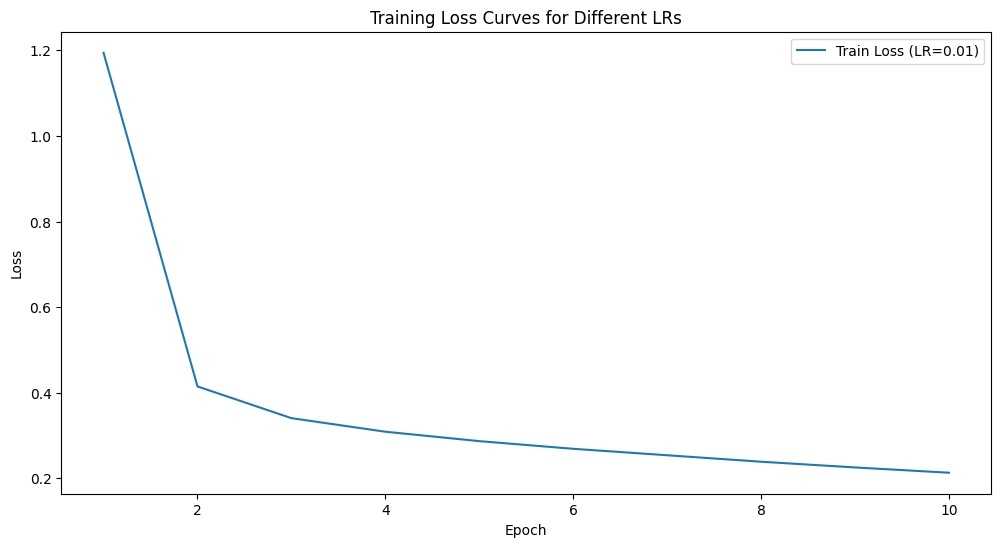

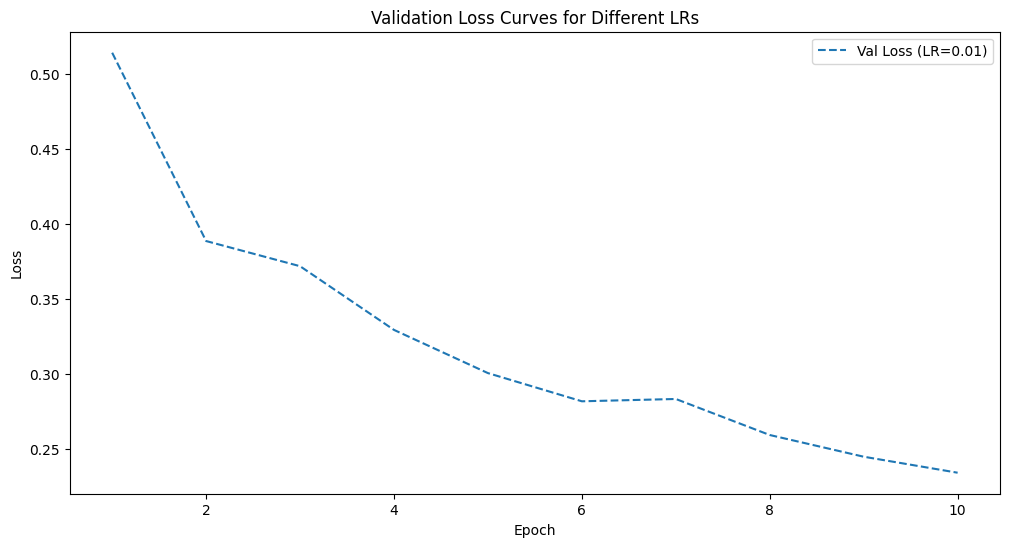

Accuracy: 93.83 %


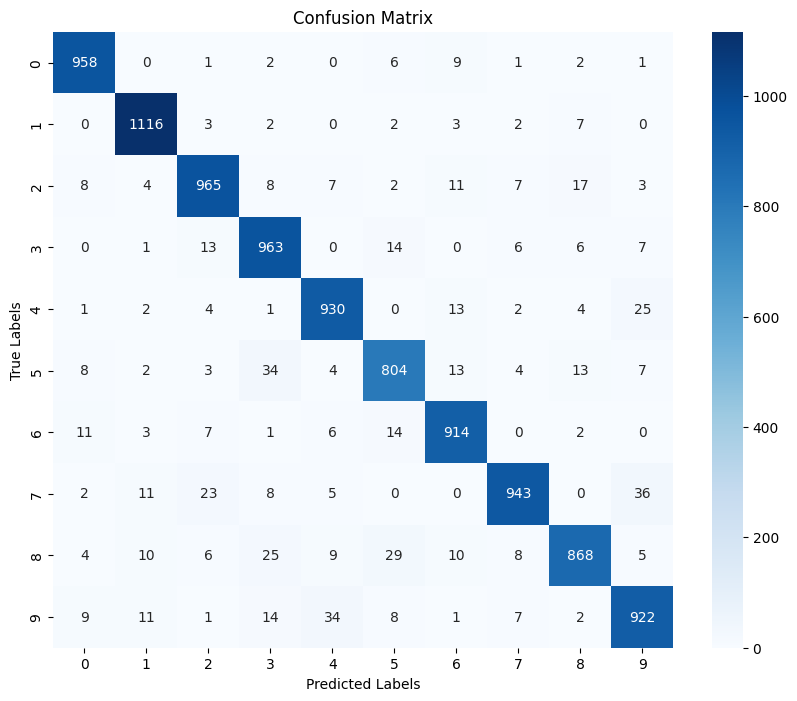

0.9383

In [14]:
# fixed parameters
input_size = 28*28      # size of image
output_size = 10        # number of digits

# hyperparameters
hidden_layers = 2
hidden_units = 60
learning_rate = 0.01
batch_size = 64

model = FeedforwardNN(input_size=input_size, output_size=output_size, hidden_layers=hidden_layers, hidden_units=hidden_units, learning_rate=learning_rate, batch_size=batch_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

train_losses, val_losses = train_model(model, train_dataset, val_dataset, criterion, optimizer, model.batch_size, model.input_size, epochs=10)
plot_loss_curves({learning_rate: train_losses}, {learning_rate: val_losses}, [learning_rate], 'LR')
test_model(model, test_dataset, model.input_size)

In [16]:
def run_experiments(param_values, param_name, fixed_params):
    """
    Runs experiments for varying one hyperparameter while keeping others fixed.

    Args:
        param_values (list): List of values to try for the hyperparameter.
        param_name (str): Name of the hyperparameter being varied.
        fixed_params (dict): Dictionary of fixed hyperparameters.

    Returns:
        dict: Training loss curves.
        dict: Validation loss curves.
        tuple: Best model, best validation loss, best parameter value.
    """
    best_model = None
    best_val_loss = float('inf')
    best_param_value = None

    train_loss_curves = {}
    val_loss_curves = {}

    for value in param_values:
        print(f"\nTraining model with {param_name} = {value}...\n")

        # Update the parameter being varied
        params = fixed_params.copy()
        params[param_name] = value

        # Initialize model
        model = FeedforwardNN(
            input_size=params['input_size'],
            output_size=params['output_size'],
            hidden_layers=params['hidden_layers'],
            hidden_units=params['hidden_units'],
            learning_rate=params['learning_rate'],
            batch_size=params['batch_size']
        )
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(model.parameters(), lr=params['learning_rate'])

        # Train the model
        train_losses, val_losses = train_model(
            model, train_dataset, val_dataset, criterion, optimizer,
            params['batch_size'], params['input_size'], epochs=20
        )

        # Save loss curves
        train_loss_curves[value] = train_losses
        val_loss_curves[value] = val_losses

        # Identify the best model
        if val_losses[-1] < best_val_loss:
            best_val_loss = val_losses[-1]
            best_model = model
            best_param_value = value

    return train_loss_curves, val_loss_curves, best_model, best_val_loss, best_param_value


# Testing Different Learning Rates

In [17]:
fixed_params = {
    'input_size': 784,
    'output_size': 10,
    'hidden_layers': 2,
    'hidden_units': 60,
    'learning_rate': 0.01,
    'batch_size': 64
}


Training model with learning_rate = 0.7...

Epoch [1/20], Train Loss: 2.3084, Val Loss: 2.3032
Epoch [2/20], Train Loss: 2.3044, Val Loss: 2.3040
Epoch [3/20], Train Loss: 2.3036, Val Loss: 2.3057
Epoch [4/20], Train Loss: 2.3039, Val Loss: 2.3056
Epoch [5/20], Train Loss: 2.3037, Val Loss: 2.3051
Epoch [6/20], Train Loss: 2.3038, Val Loss: 2.3019
Epoch [7/20], Train Loss: 2.3038, Val Loss: 2.3033
Epoch [8/20], Train Loss: 2.3045, Val Loss: 2.3033
Epoch [9/20], Train Loss: 2.3039, Val Loss: 2.3043
Epoch [10/20], Train Loss: 2.3038, Val Loss: 2.3052
Epoch [11/20], Train Loss: 2.3035, Val Loss: 2.3077
Epoch [12/20], Train Loss: 2.3041, Val Loss: 2.3054
Epoch [13/20], Train Loss: 2.3032, Val Loss: 2.3038
Epoch [14/20], Train Loss: 2.3037, Val Loss: 2.3065
Epoch [15/20], Train Loss: 2.3040, Val Loss: 2.3062
Epoch [16/20], Train Loss: 2.3038, Val Loss: 2.3074
Epoch [17/20], Train Loss: 2.3040, Val Loss: 2.3032
Epoch [18/20], Train Loss: 2.3034, Val Loss: 2.3039
Epoch [19/20], Train Loss: 2

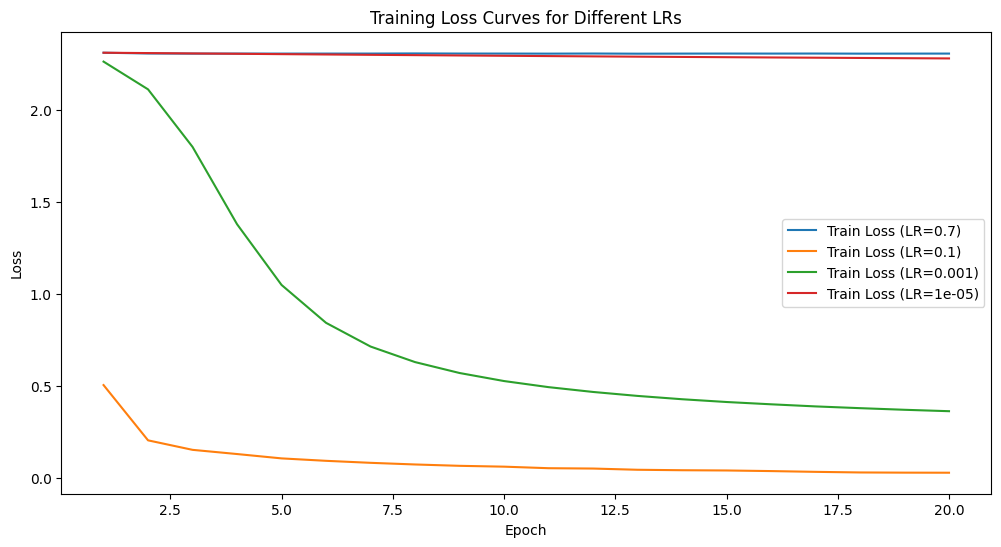

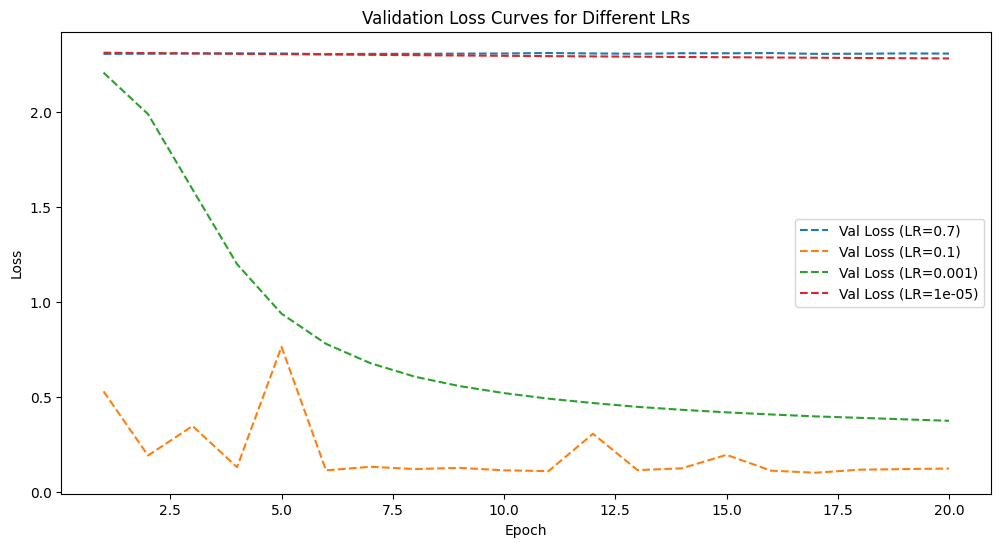


Best learning rate: 0.1 (Validation Loss: 0.1227)

Accuracy: 96.73 %


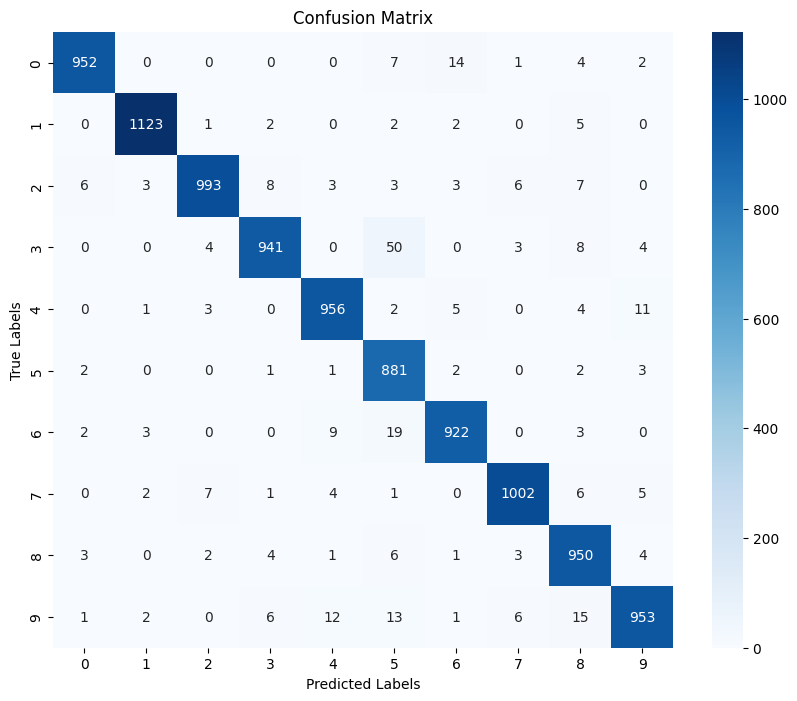

In [18]:
# Experiment 1: Vary learning rate
learning_rates = [0.7, 0.1, 0.001, 0.00001]
train_loss_curves, val_loss_curves, best_model, best_val_loss, best_learning_rate = run_experiments(
    learning_rates, 'learning_rate', fixed_params
)
plot_loss_curves(train_loss_curves, val_loss_curves, learning_rates, 'LR')
print(f"\nBest learning rate: {best_learning_rate} (Validation Loss: {best_val_loss:.4f})\n")
LR_acc = test_model(best_model, test_dataset, best_model.input_size)


Training model with batch_size = 1...

Epoch [1/20], Train Loss: 0.4116, Val Loss: 0.2925
Epoch [2/20], Train Loss: 0.2655, Val Loss: 0.2570
Epoch [3/20], Train Loss: 0.2330, Val Loss: 0.1894
Epoch [4/20], Train Loss: 0.2060, Val Loss: 0.2486
Epoch [5/20], Train Loss: 0.1990, Val Loss: 0.3174
Epoch [6/20], Train Loss: 0.1847, Val Loss: 0.2386
Epoch [7/20], Train Loss: 0.1770, Val Loss: 0.2289
Epoch [8/20], Train Loss: 0.1734, Val Loss: 0.2622
Epoch [9/20], Train Loss: 0.1718, Val Loss: 0.2298
Epoch [10/20], Train Loss: 0.1688, Val Loss: 0.2244
Epoch [11/20], Train Loss: 0.1637, Val Loss: 0.2593
Epoch [12/20], Train Loss: 0.1676, Val Loss: 0.3148
Epoch [13/20], Train Loss: 0.1607, Val Loss: 0.2409
Epoch [14/20], Train Loss: 0.1685, Val Loss: 0.2770
Epoch [15/20], Train Loss: 0.1594, Val Loss: 0.2263
Epoch [16/20], Train Loss: 0.1580, Val Loss: 0.2266
Epoch [17/20], Train Loss: 0.1651, Val Loss: 0.2842
Epoch [18/20], Train Loss: 0.1650, Val Loss: 0.2944
Epoch [19/20], Train Loss: 0.1569

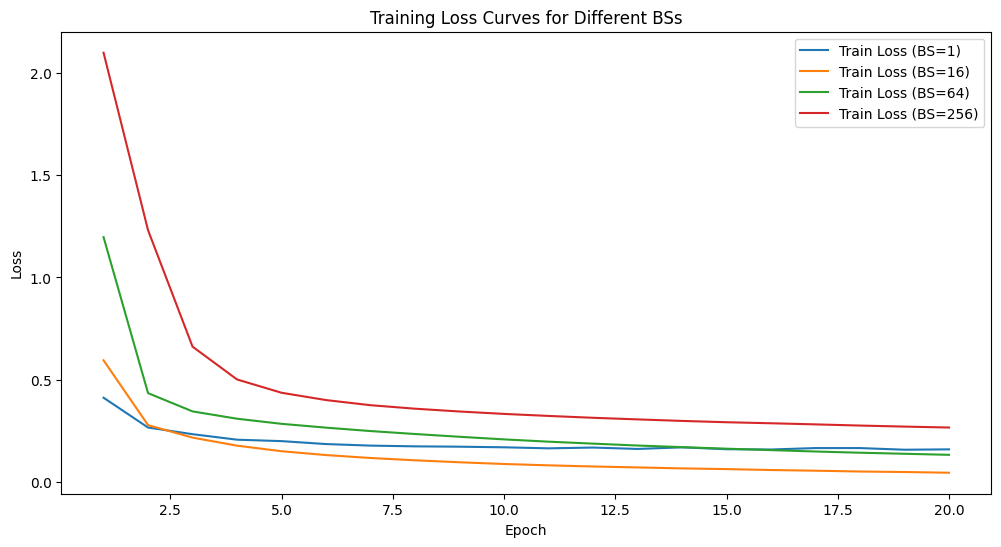

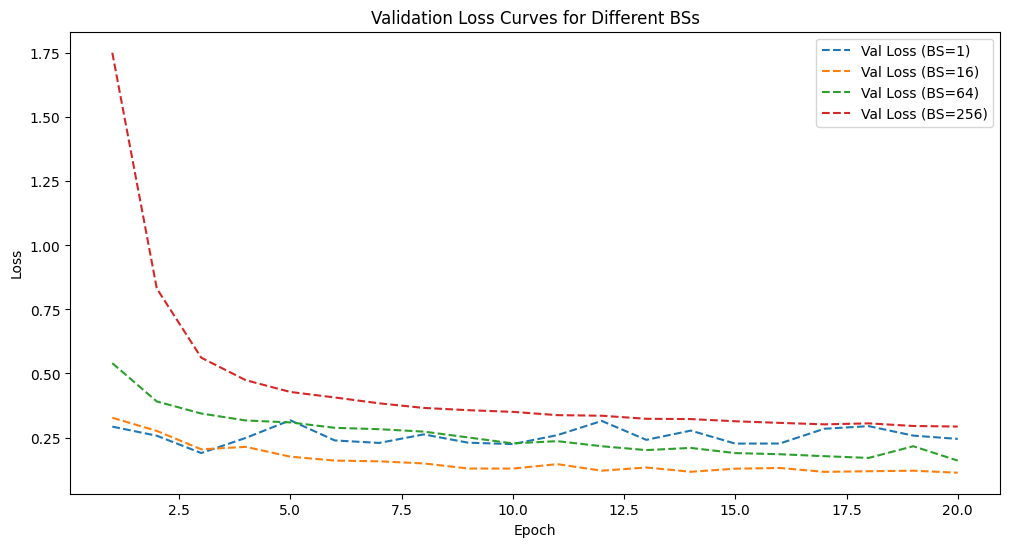


Best batch size: 16 (Validation Loss: 0.1126)

Accuracy: 97.31 %


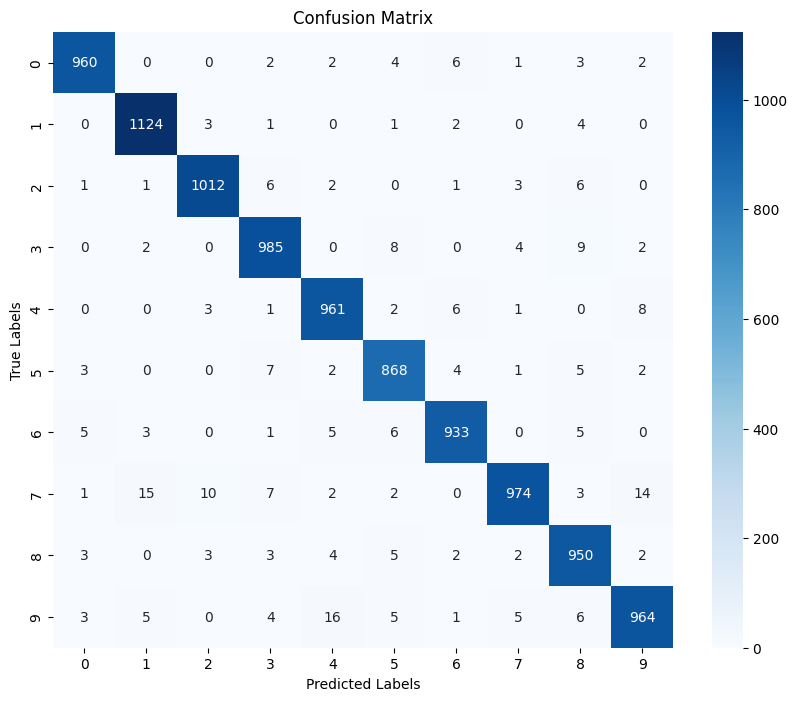

In [19]:
# Experiment 2: Vary batch size
batch_sizes = [1, 16, 64, 256]
train_loss_curves, val_loss_curves, best_model, best_val_loss, best_batch_size = run_experiments(
    batch_sizes, 'batch_size', fixed_params
)
plot_loss_curves(train_loss_curves, val_loss_curves, batch_sizes, 'BS')
print(f"\nBest batch size: {best_batch_size} (Validation Loss: {best_val_loss:.4f})\n")
batch_size_acc = test_model(best_model, test_dataset, best_model.input_size)


Training model with hidden_layers = 3...

Epoch [1/20], Train Loss: 0.8504, Val Loss: 0.3772
Epoch [2/20], Train Loss: 0.3037, Val Loss: 0.2774
Epoch [3/20], Train Loss: 0.2299, Val Loss: 0.2308
Epoch [4/20], Train Loss: 0.1858, Val Loss: 0.1866
Epoch [5/20], Train Loss: 0.1564, Val Loss: 0.1795
Epoch [6/20], Train Loss: 0.1352, Val Loss: 0.1582
Epoch [7/20], Train Loss: 0.1210, Val Loss: 0.1419
Epoch [8/20], Train Loss: 0.1085, Val Loss: 0.1421
Epoch [9/20], Train Loss: 0.0984, Val Loss: 0.1441
Epoch [10/20], Train Loss: 0.0915, Val Loss: 0.1291
Epoch [11/20], Train Loss: 0.0850, Val Loss: 0.1338
Epoch [12/20], Train Loss: 0.0779, Val Loss: 0.1161
Epoch [13/20], Train Loss: 0.0731, Val Loss: 0.1253
Epoch [14/20], Train Loss: 0.0682, Val Loss: 0.1190
Epoch [15/20], Train Loss: 0.0641, Val Loss: 0.1089
Epoch [16/20], Train Loss: 0.0594, Val Loss: 0.1121
Epoch [17/20], Train Loss: 0.0558, Val Loss: 0.1198
Epoch [18/20], Train Loss: 0.0531, Val Loss: 0.1235
Epoch [19/20], Train Loss: 0.0

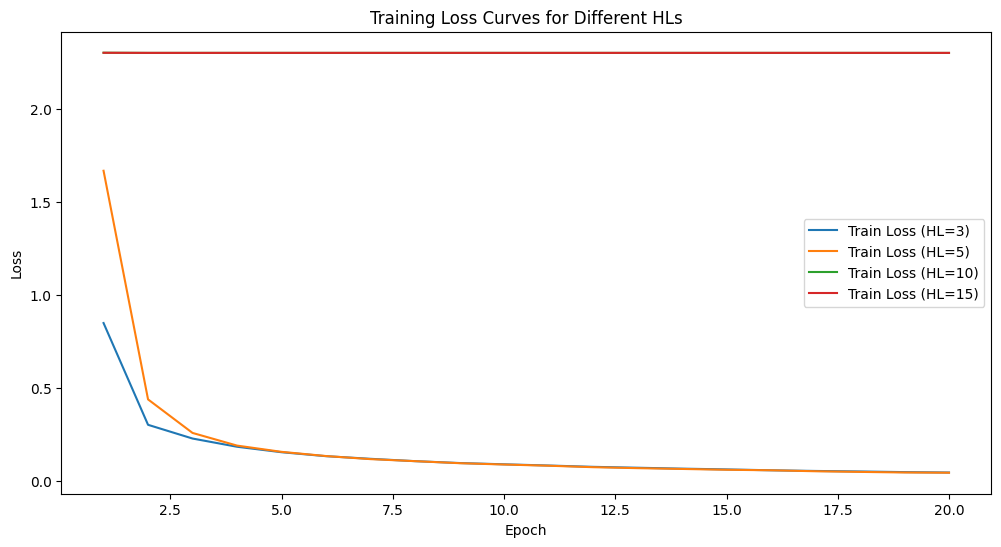

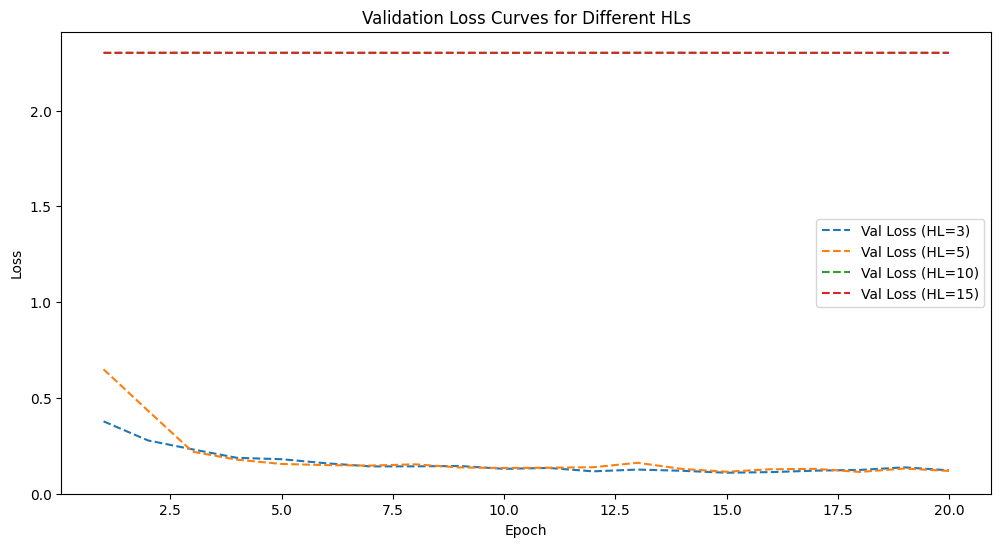


Best number of hidden layers: 5 (Validation Loss: 0.1182)

Accuracy: 96.67 %


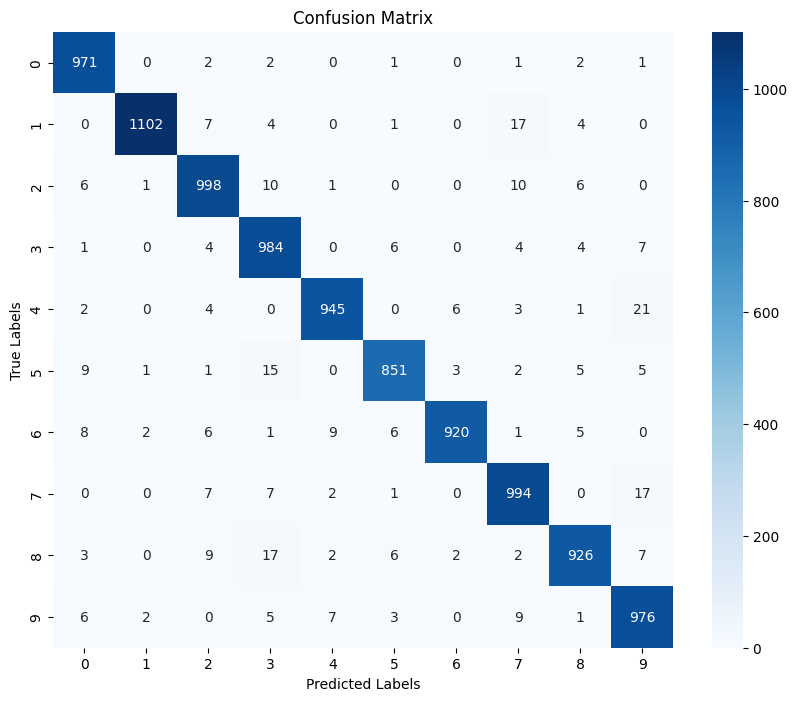

In [20]:
# Experiment 3: Vary number of hidden layers
hidden_layers_list = [3, 5, 10, 15  ]
fixed_params['batch_size'] = best_batch_size
train_loss_curves, val_loss_curves, best_model, best_val_loss, best_hidden_layers = run_experiments(
    hidden_layers_list, 'hidden_layers', fixed_params
)
plot_loss_curves(train_loss_curves, val_loss_curves, hidden_layers_list, 'HL')
print(f"\nBest number of hidden layers: {best_hidden_layers} (Validation Loss: {best_val_loss:.4f})\n")
hidden_layers_acc = test_model(best_model, test_dataset, best_model.input_size)



Training model with hidden_units = 5...

Epoch [1/20], Train Loss: 2.3005, Val Loss: 2.2847
Epoch [2/20], Train Loss: 2.0098, Val Loss: 1.6516
Epoch [3/20], Train Loss: 1.5193, Val Loss: 1.4076
Epoch [4/20], Train Loss: 1.2284, Val Loss: 1.0792
Epoch [5/20], Train Loss: 0.9815, Val Loss: 0.9134
Epoch [6/20], Train Loss: 0.8993, Val Loss: 0.8733
Epoch [7/20], Train Loss: 0.8517, Val Loss: 0.8376
Epoch [8/20], Train Loss: 0.8066, Val Loss: 0.8027
Epoch [9/20], Train Loss: 0.7690, Val Loss: 0.7928
Epoch [10/20], Train Loss: 0.7387, Val Loss: 0.7792
Epoch [11/20], Train Loss: 0.7165, Val Loss: 0.7251
Epoch [12/20], Train Loss: 0.6997, Val Loss: 0.7308
Epoch [13/20], Train Loss: 0.6888, Val Loss: 0.7226
Epoch [14/20], Train Loss: 0.6718, Val Loss: 0.7015
Epoch [15/20], Train Loss: 0.6575, Val Loss: 0.6959
Epoch [16/20], Train Loss: 0.6400, Val Loss: 0.6688
Epoch [17/20], Train Loss: 0.6153, Val Loss: 0.6377
Epoch [18/20], Train Loss: 0.5969, Val Loss: 0.6589
Epoch [19/20], Train Loss: 0.58

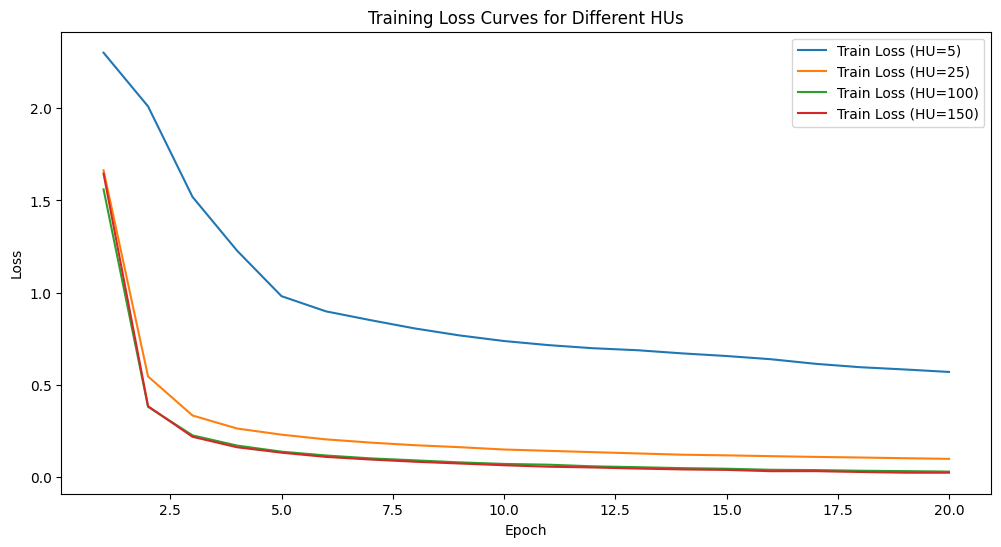

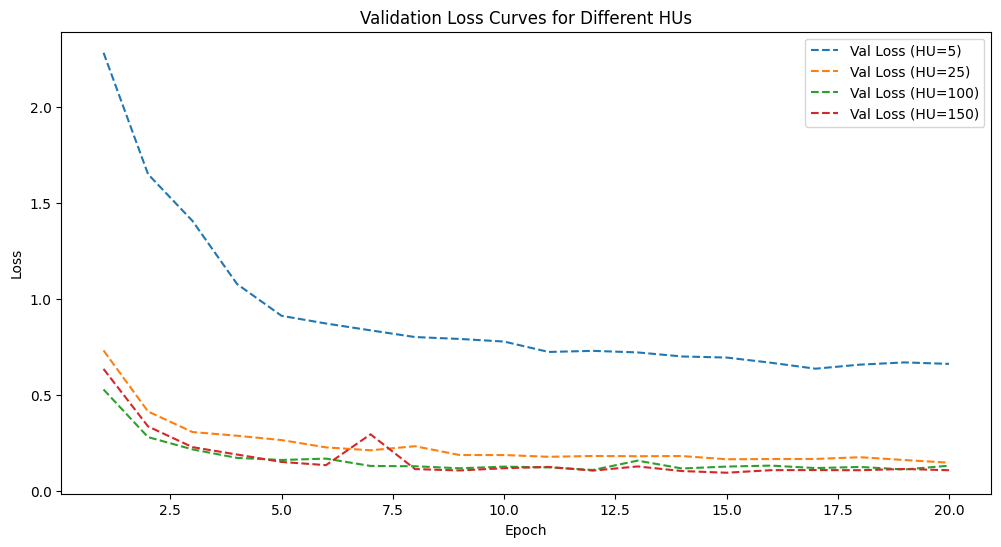


Best number of neurons: 150 (Validation Loss: 0.1086)

Accuracy: 97.52 %


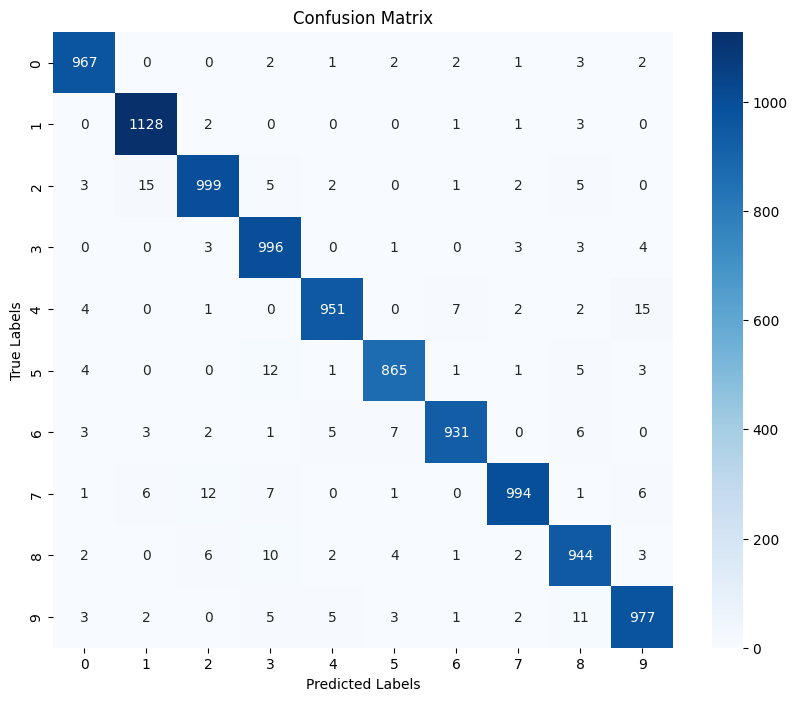

In [21]:
# Experiment 4: Vary number of neurons
num_neurons_list = [5, 25, 100, 150]
fixed_params['hidden_layers'] = best_hidden_layers
train_loss_curves, val_loss_curves, best_model, best_val_loss, best_num_neurons = run_experiments(
    num_neurons_list, 'hidden_units', fixed_params
)
plot_loss_curves(train_loss_curves, val_loss_curves, num_neurons_list, 'HU')
print(f"\nBest number of neurons: {best_num_neurons} (Validation Loss: {best_val_loss:.4f})\n")
neurons_acc = test_model(best_model, test_dataset, best_model.input_size)